### The Black-Scholes hedging strategy

In [193]:
# import
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as scnorm

#### 1- Program which produces a sample of N = 1000 copies of the discrete path {$ S_{t_i}, ~ i = 0, ..., n$}

In [194]:
# initialisation
N = 1000
n = 100
T = 1.5
sigma = 0.3
S0 = 100
# construction of bronian motion W
def brown(T, n):
    delta_T = T/n
    Z_i = np.random.randn(n)*(delta_T**0.5) # n simulations indépendantes d'une va gaussienne centré
                                            # et de variance delta_T
    W = np.zeros(n+1)
    W[1:] = np.cumsum(Z_i)
    return W

In [195]:
def S_t(T = 1.5,S0 = 100,sigma = 0.3, mu = 0.05 , n = 5):
    W = brown(T, n)
    t = np.array([i*T/n for i in range(n+1)])

    return S0*np.exp((mu - (sigma**2)/2)*t - sigma*W)


Text(0, 0.5, 'Process $S_t$')

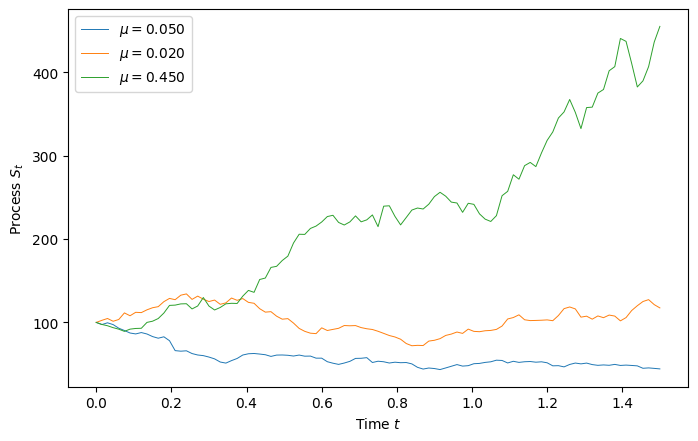

In [196]:
# le tracer

fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

# liste de valeurs temporelles 
t = [i*T/n for i in range(n+1)]
# liste de mu
mu_list = [0.05, 0.02, 0.45]
# echantillons de données
S = []

for mu in mu_list:
    S.append([S_t(T,S0, sigma, mu, n) for _ in range(N)]) # Nx(n+1)
    graph_traj = S[-1][0]
    ax.plot(t, graph_traj, linewidth=0.7,
            label=r"$\mu = %.3f$" % mu)
S = np.array(S)
ax.legend()
ax.set_xlabel("Time $t$")
ax.set_ylabel("Process $S_t$")

In [197]:
# Compute corresponding sample mean and variance and comment the values 

for i in range(3): # pour  chaque valeur de mu
    print("mean for mu =: %.3f" % mu_list[i], " is %.3f"% np.mean(S[i, :, -1]))
    print("variance for mu =: %.3f" % mu_list[i], " is %.3f"% np.var(S[i, :, -1]))
    print("\n")

mean for mu =: 0.050  is 110.170
variance for mu =: 0.050  is 1944.558


mean for mu =: 0.020  is 102.963
variance for mu =: 0.020  is 1539.571


mean for mu =: 0.450  is 200.749
variance for mu =: 0.450  is 6124.188




>> 0n remarque que la moyenne et la variance augmentent avec mu 

>>> puisque   $E[S_T] = exp((μ - \frac{1}{2}σ^2)T)E[exp(σW_T)]$
>>> et        $Var[S_T] = exp((2μ -σ^2)T)Var(exp(\sigma W_T))$

#### 2- 

##### 2_1 - Simulate a sample of N = 1000 copies of $X_{T}^{n}$ for each values of $μ$ Use the values of $K$ in {$ 100 ± i, ~ i = 0, ..., 20$}

In [204]:
def BS(S0, K, T, r, sigma):

    k = K*np.exp(-r*T)
    v = (sigma**2)*(T)
    d = np.log(S0/k)/np.sqrt(v) + 0.5*v**0.5 # +
    d_ = np.log(S0/k)/np.sqrt(v) - 0.5*v**0.5 # -

    return S0*scnorm.cdf(d) - k*np.exp(-r*T)*scnorm.cdf(d_)

In [199]:
def delta_t_K(S0,K, T, r, sigma, mu, n, t):

    s = S_t(T,S0, sigma, mu, n)[:len(t)]

    k = K*np.exp(-r*(T-t))
  
    v = (sigma**2)*(T-t)

    d = np.log(s/k)/np.sqrt(v) + 0.5*np.sqrt(s) # +
    return scnorm.cdf(d)

In [205]:
# X_T^n

def X_T_n (S0,K, T, r, mu, sigma, n):
    bs = BS(S0, K, T, sigma, r)     # Black-Scholes
    t = np.array([i*T/n for i in range(n+1)])
    t_tronc= t[:-1] 
    t = t[1:]

    deltas = delta_t_K(S0, K, T, r, sigma, mu, n, t_tronc)
    
    St = S_t(n, T, mu, sigma, S0)
    St_inv = St[:-1] 
    St = St[1:]
    res = bs + np.sum(deltas*(np.exp(-r*t)*St - np.exp(-r*t_tronc)*St_inv), axis=0)
    return np.exp(r*T)*res

In [201]:
# initialisation
t = np.array([i*T/n for i in range(n+1)])
mu_list = [0.05, 0.02, 0.45]
K_list = list(range(80,121)) # puisque K_list est dans {100 ±i, i = 0, ..., 20}
r = 0.05
# échantillonage 
Sample = []
for K in K_list:
    K_sample_data = []
    for mu in mu_list:
        K_sample_data.append([X_T_n(S0,K, T, r , mu, sigma, n) for _ in range(N)])
    Sample.append(K_sample_data)
Sample = np.array(Sample)

#### Calculons la moyenne des N = 1000 echantillions en fonction de $μ$ pour les différentes valeurs de $K$

In [202]:
# mean
mean = np.mean(Sample, axis= 2)

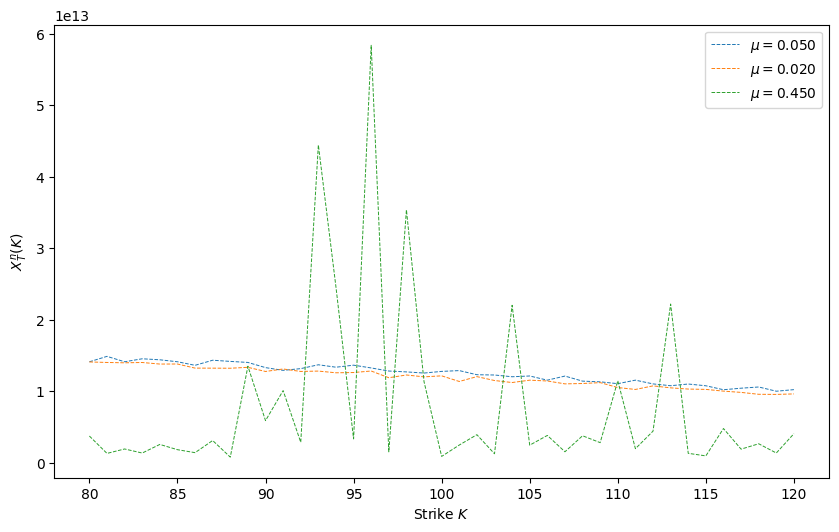

In [203]:
# Tracer 
fig, ax = plt.subplots(1,1,figsize=(10,6),dpi=100)
ax.set_xlabel("Strike $K$")
ax.set_ylabel("$X_T^n(K)$")

for i, mu in enumerate(mu_list):
    ax.plot(K_list, mean[:,i], linestyle='--', label=r"$\mu=%.3f$" % mu, linewidth=0.7)

ax.legend()

#### 2_2 - Compute the corresponding Pro t and Loss 

In [208]:
def PL(n, T, K, S0, mu, sigma, r=0.05):
    bs = BS(S0, K, T, r, sigma)
    t = np.array([i*T/n for i in range(n+1)])
    t_tronc = t[:-1]
    t = t[1:]
    deltas = delta_t_K(S0,K, T, r, sigma, mu, n, t)
    St = S_t(T,S0,sigma, mu, n)
    S_terminal = St[-1]
    St_tronc = St[:-1]
    St = St[1:]
    res = bs + np.sum(deltas*(np.exp(-r*t)*St - np.exp(-r*t_tronc)*St_tronc), axis=0)
    res = np.exp(r*T)*res
    return res - max(0, S_terminal - K)

In [216]:
# tracer

n_list = [128, 512, 1024, 2048]

pl_sample = []

for n in n_list:
    n_sample_data = []
    for K in K_list:
        K_sample_data = []
        for mu in mu_list:
            K_sample_data.append([PL(n, T, K, S0, mu, sigma) for _ in range(N)])
        print(' done')
        n_sample_data.append(K_sample_data)
    pl_sample.append(n_sample_data)

/var/folders/zy/bdpsbv4x0fg3yn4wlt_54gzw0000gn/T/ipykernel_66000/2733258951.py:9: RuntimeWarning: divide by zero encountered in true_divide
  d = np.log(s/k)/np.sqrt(v) + 0.5*np.sqrt(s) # +


 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done
 done


In [217]:
# mean of the profit loss
pl_sample = np.array(pl_sample)
mean = np.mean(pl_sample, axis= -1)
variance = np.var(pl_sample, axis= -1)

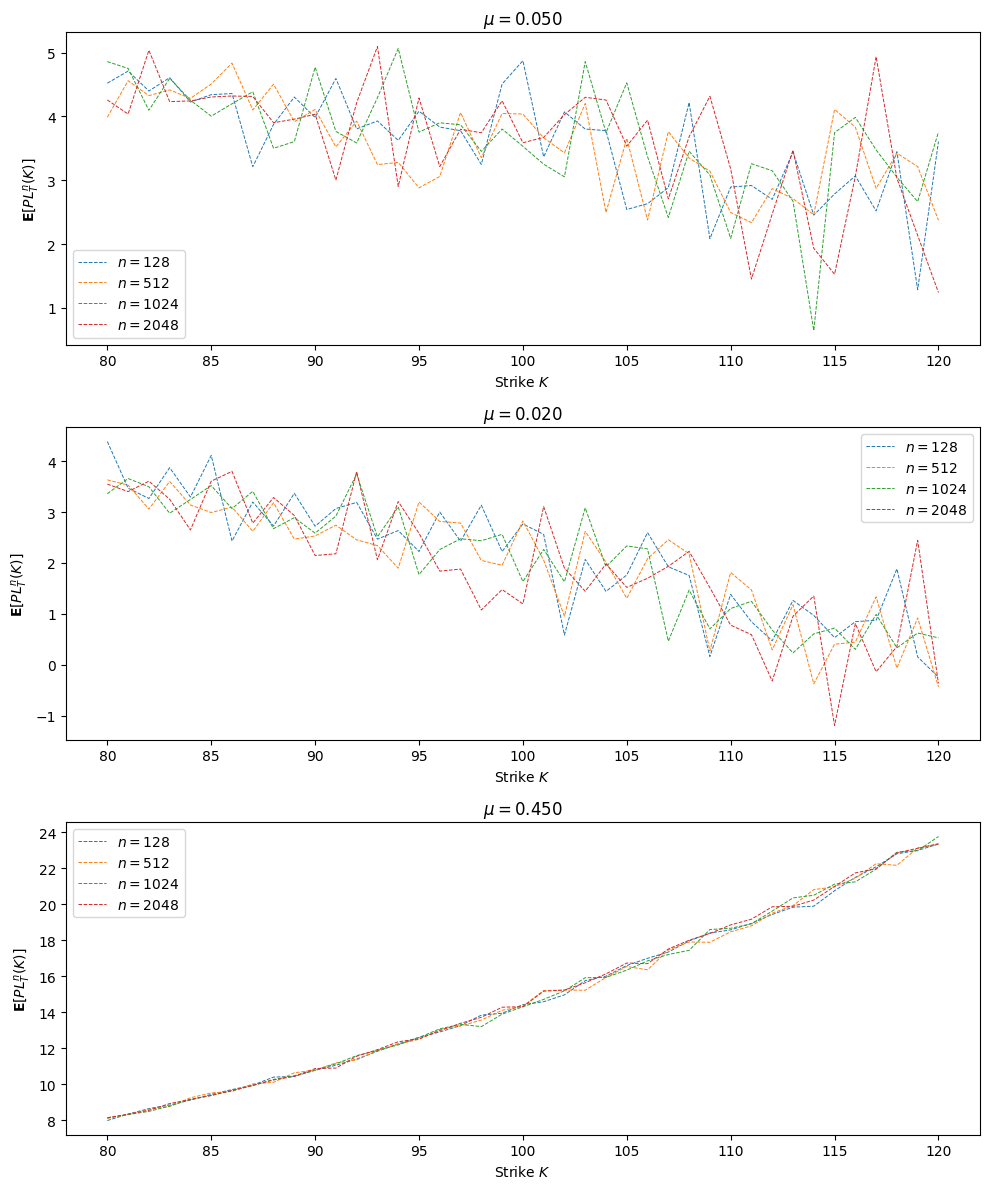

In [219]:
# afficher la moyenne du profit loss

fig, axes = plt.subplots(3,1,figsize=(10,12),dpi=100)

for i, mu in enumerate(mu_list):
    for j, n in enumerate(n_list):
        axes[i].plot(
            K_list, mean[j,:,i],
            linestyle='--', label=r"$n=%d$" % n, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathbf{E}[PL_T^n(K)]$")
fig.tight_layout()

>>> On voit toujours la croissance suivant mu

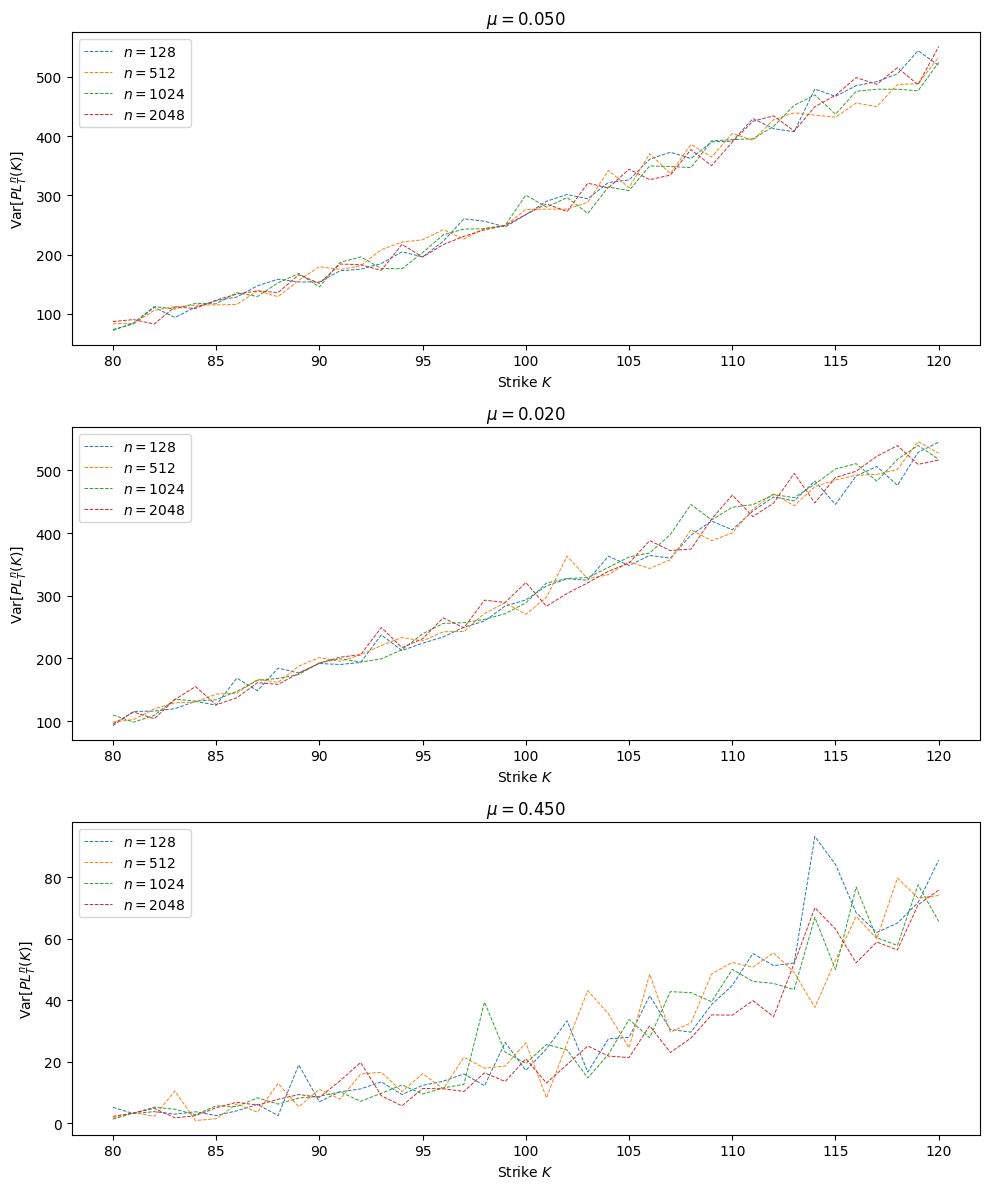

In [220]:
#afficher la variance du profite loss

fig, axes = plt.subplots(3,1,figsize=(10,12),dpi=100)

for i, mu in enumerate(mu_list):
    for j, n in enumerate(n_list):
        axes[i].plot(
            K_list, variance[j,:,i],
            linestyle='--', label=r"$n=%d$" % n, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathrm{Var}[PL_T^n(K)]$")
fig.tight_layout()

>>> Egalement pour la variance on a une croissance en fonction de mu